<a href="https://colab.research.google.com/github/29kirti/Brain-tumor-classification-model-using-VGG16/blob/main/Brain_tumor_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import label_binarize

In [16]:
from google.colab import drive
import zipfile
import os
from google.colab import drive
drive.mount('/content/drive') # Mount Google Drive

import zipfile
import os

# Step 2: Unzip the Dataset
zip_path = '/content/drive/MyDrive/MRI_BASED.zip'  # Path to the zip file
extract_path = '/content/drive/MyDrive/MRI_BASED/'  # Destination folder

# Unzip the file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print(f'Dataset extracted to {extract_path}')

# Verify Extracted Directories
print("Extracted Folders:", os.listdir(extract_path))

# Assuming 'base_dir' should be 'extract_path' based on the context
train_dir = os.path.join(extract_path, "Training")
test_dir = os.path.join(extract_path, "Testing")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Dataset extracted to /content/drive/MyDrive/MRI_BASED/
Extracted Folders: ['Testing', 'Training']


In [17]:
import tensorflow as tf

# Load the training dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    image_size=(224, 224),
    batch_size=32,
    label_mode='categorical'  # Assuming multiple tumor classes
)

# Load the testing dataset
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    image_size=(224, 224),
    batch_size=32,
    label_mode='categorical'
)


Found 5712 files belonging to 4 classes.
Found 1311 files belonging to 4 classes.


In [18]:
# Data Augmentation
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomContrast(0.2)
])

train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))




In [19]:
# Normalize the datasets
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))


In [20]:
train_ds = train_ds.prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=tf.data.AUTOTUNE)

# Class weights (adjust based on your class distribution)
class_weights = {0: 1.0, 1: 1.0, 2: 1.0, 3: 1.0}


In [21]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam


# Load the VGG16 model without the top layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model
base_model.trainable = False

# Build the model
model = Sequential([
    base_model,
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(4, activation='softmax')  # Assuming 4 classes
])

# Unfreeze some layers of the base model
base_model.trainable = True
for layer in base_model.layers[:10]:
    layer.trainable = False


In [22]:
# Compile the model with a lower learning rate
model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 7, 7, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 512)                 │      12,845,568 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 4)                   │           1,028 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 27,692,612 (105.64 MB)

 Trainable params: 25,957,124 (99.02 MB)

 Non-trainable params: 1,735,488 (6.62 MB)

In [24]:

from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau


#Define early stopping and learning rate reduction
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

# Train the model with 20 epochs, Early Stopping, and Learning Rate Reduction
history = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=20,
    callbacks=[early_stop, reduce_lr],
    class_weight=class_weights
)

Epoch 1/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 143s 694ms/step - accuracy: 0.4241 - loss: 1.3263 - val_accuracy: 0.7490 - val_loss: 0.6693 - learning_rate: 1.0000e-05
Epoch 2/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 127s 705ms/step - accuracy: 0.7627 - loss: 0.6372 - val_accuracy: 0.7773 - val_loss: 0.5635 - learning_rate: 1.0000e-05
Epoch 3/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 135s 667ms/step - accuracy: 0.8297 - loss: 0.4792 - val_accuracy: 0.8436 - val_loss: 0.4375 - learning_rate: 1.0000e-05
Epoch 4/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 147s 697ms/step - accuracy: 0.8590 - loss: 0.3863 - val_accuracy: 0.8711 - val_loss: 0.3716 - learning_rate: 1.0000e-05
Epoch 5/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 120s 667ms/step - accuracy: 0.8802 - loss: 0.3531 - val_accuracy: 0.8780 - val_loss: 0.3458 - learning_rate: 1.0000e-05
Epoch 6/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 146s 689ms/step - accuracy: 0.8935 - loss: 0.2891 - val_accuracy: 0.8711 - val_loss: 0.3646 - learning_rate: 1.0000e-05
Epoch 7/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 

In [25]:
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test Accuracy: {test_acc:.2f}")


41/41 ━━━━━━━━━━━━━━━━━━━━ 7s 172ms/step - accuracy: 0.9628 - loss: 0.1014
Test Accuracy: 0.96


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

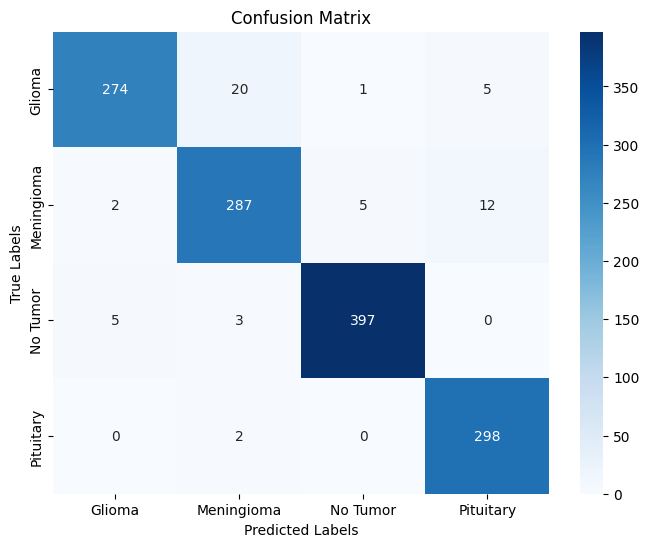

Classification Report:
               precision    recall  f1-score   support

      Glioma       0.98      0.91      0.94       300
  Meningioma       0.92      0.94      0.93       306
    No Tumor       0.99      0.98      0.98       405
   Pituitary       0.95      0.99      0.97       300

    accuracy                           0.96      1311
   macro avg       0.96      0.96      0.96      1311
weighted avg       0.96      0.96      0.96      1311



In [26]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.preprocessing import label_binarize

# Get true labels and predictions
true_labels = []
predicted_probs = []
predicted_labels = []

for images, labels in test_ds:
    preds = model.predict(images)  # Get predicted probabilities
    predicted_probs.extend(preds)
    predicted_labels.extend(np.argmax(preds, axis=1))  # Convert to class labels
    true_labels.extend(np.argmax(labels.numpy(), axis=1))  # True class labels

# Define class names
class_names = ['Glioma', 'Meningioma', 'No Tumor', 'Pituitary']

# Compute confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

# Print Classification Report
print("Classification Report:\n", classification_report(true_labels, predicted_labels, target_names=class_names))


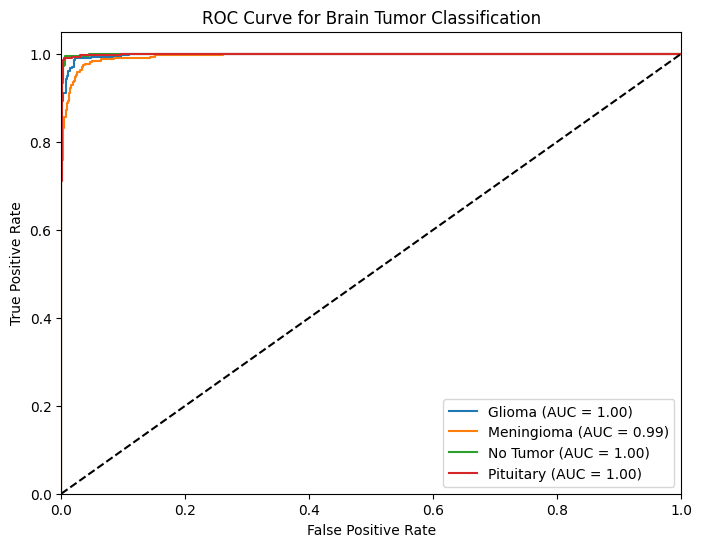

In [27]:
from sklearn.metrics import  roc_curve, auc
from sklearn.preprocessing import label_binarize
# Compute ROC curve and AUC
true_labels_bin = label_binarize(true_labels, classes=[0, 1, 2, 3])
n_classes = true_labels_bin.shape[1]
fpr, tpr, roc_auc = {}, {}, {}

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(true_labels_bin[:, i], np.array(predicted_probs)[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC Curves
plt.figure(figsize=(8, 6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'{class_names[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # Random chance line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Brain Tumor Classification')
plt.legend(loc='lower right')
plt.show()

In [32]:
# Function to preprocess and predict the class of an uploaded image
def classify_image(image_path, model, class_names):
    # Load the image
    img = load_img(image_path, target_size=(224, 224))

    # Convert the image to an array
    img_array = img_to_array(img)

    # Expand dimensions to match the input shape of the model
    img_array = np.expand_dims(img_array, axis=0)

    # Normalize the image
    img_array = img_array / 255.0

    # Predict the class
    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions, axis=1)

    # Get the class name
    class_name = class_names[predicted_class[0]]

    return class_name


image_path = '/content/Te-_0005.jpg'
class_name = classify_image(image_path, model, class_names)
print(f'The image is classified as: {class_name}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
The image is classified as: Pituitary


In [33]:
# Save the model
model.save('/content/drive/MyDrive/brain_tumor_classification_model.keras')
